In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
from test_data import experiment_data,add_noise,normalise_frobenius,normalise_minmax

# Algebraic function with non unique polynomial PDE: $u(t,x)=\frac{1}{x+t}$
The function $u$ solves the equations $u_t = u_x$ and $u_t= -u^2$. We can now actually show that the Jacobi criterion for algbraic functions yields non-uniqueness.

In [3]:
experiment_name = 'algebraic_nonunique_1'
u,x,t,formula = experiment_data(n_samples=200,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

algebraic_nonunique_1
1/(t + x)


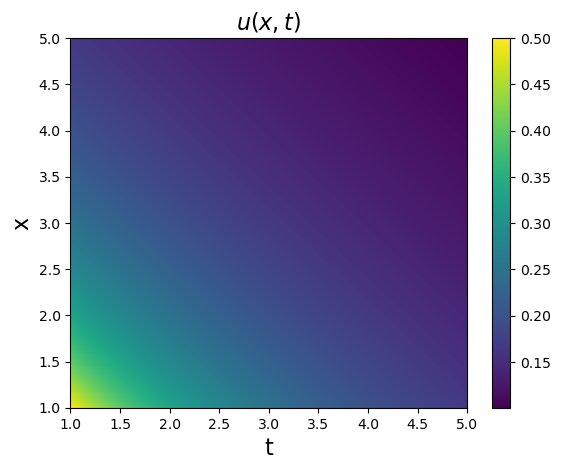

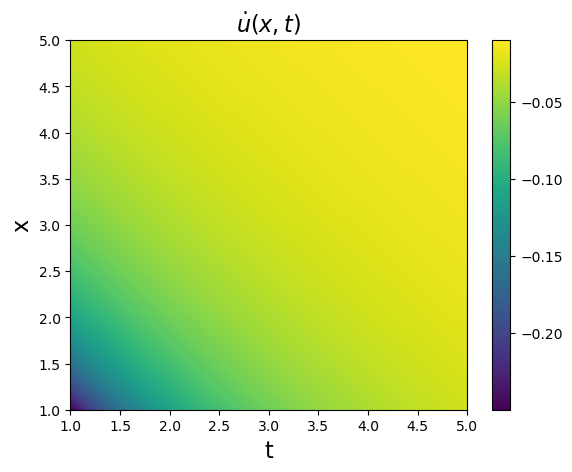

In [4]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

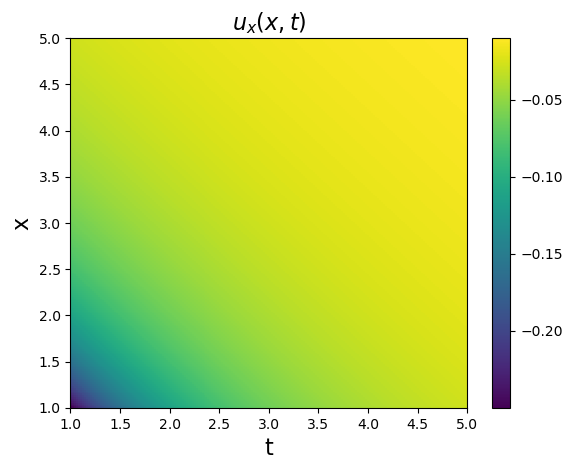

In [5]:
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)


# Plot derivative results
plt.pcolormesh(t, x, ux)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.colorbar()
plt.show()

## Check now numerically if this is the unique equation

We already know that the equation is not unique. Assuming we know that the function is algebraic, we want to show the uniqueness now by applying the Jacobi criterion for algebraic functions.
### Jacobi criterion

In [6]:
from utils import plot_result_jacobi
def jacobi_criterion(u,space_range,time_range,fd_orders,target_noise=0,normalise=None):
    u_noise = add_noise(u,target_noise)
    sv_ratios = np.zeros([space_range, time_range])
    svs = np.zeros([2, space_range, time_range])
    for k, fd_order in enumerate(fd_orders):
        ut = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u_noise, t=dt)
        utx = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut, dx)
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u_noise, dx) 
        for i in range(space_range):
            for j in range(time_range):
                x_i, t_j = i * 10 + 10, j * 10 + 10
                jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
                if normalise!=None:
                    jacobian=normalise(jacobian)
                sv = svd(jacobian, compute_uv=False)[-1]
                svs[k,i,j] = sv
    return svs

In [7]:
from numpy.linalg import matrix_rank, svd

In [8]:
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)
print((space_range,time_range))
fd_orders = [2, 7]
svs = jacobi_criterion(u,space_range,time_range,fd_orders)

(19, 19)


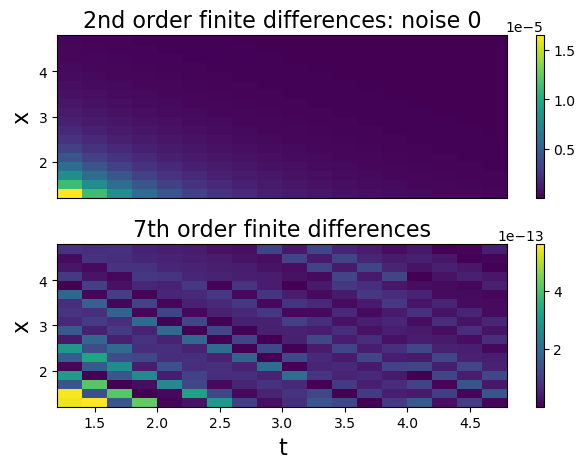

In [9]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) /len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
plot_result_jacobi(svs,t_grid,x_grid,fd_orders=fd_orders)

## With noise

#### No normalisation 

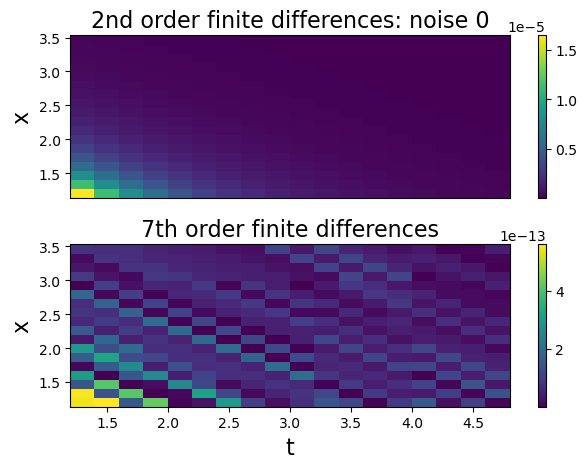

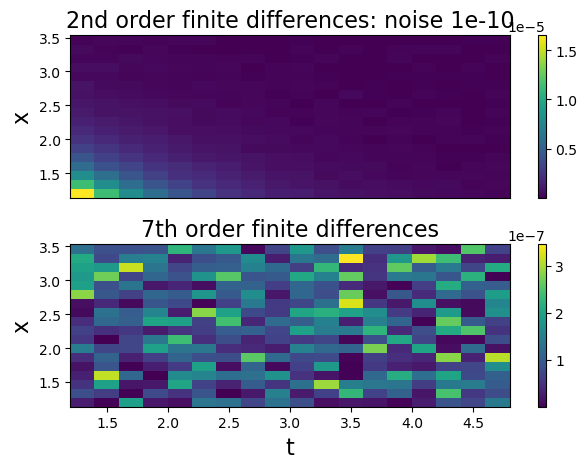

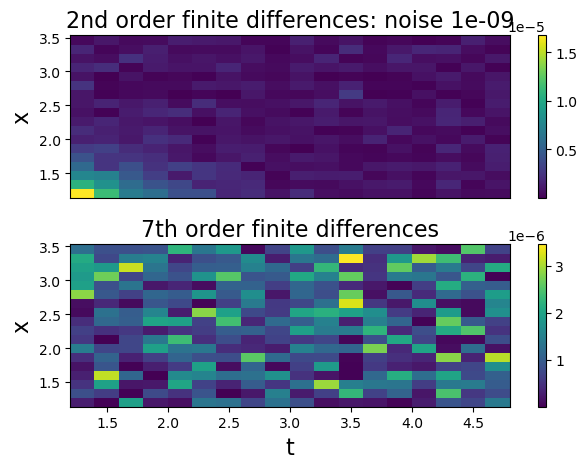

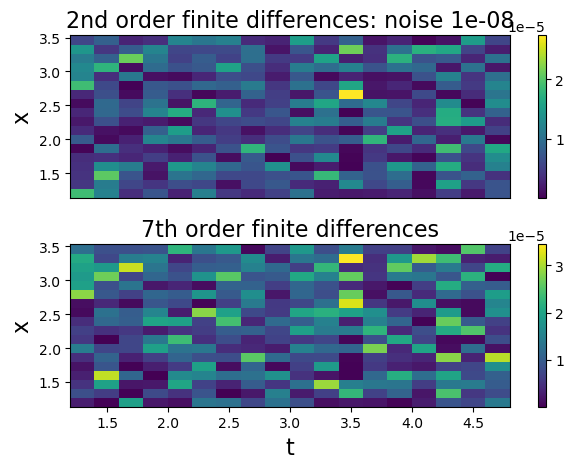

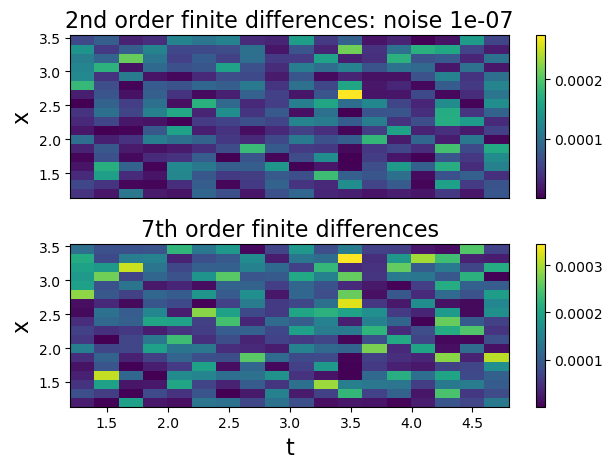

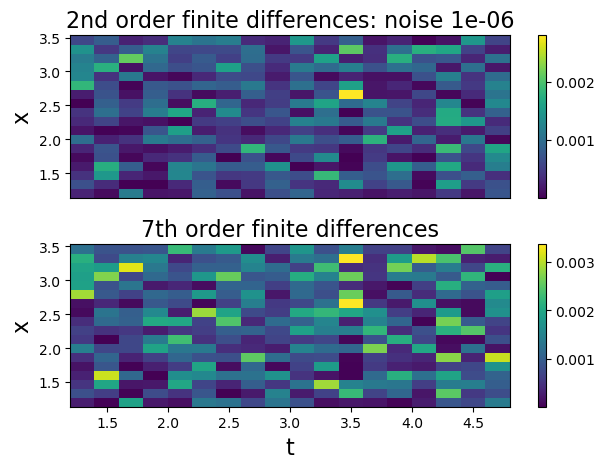

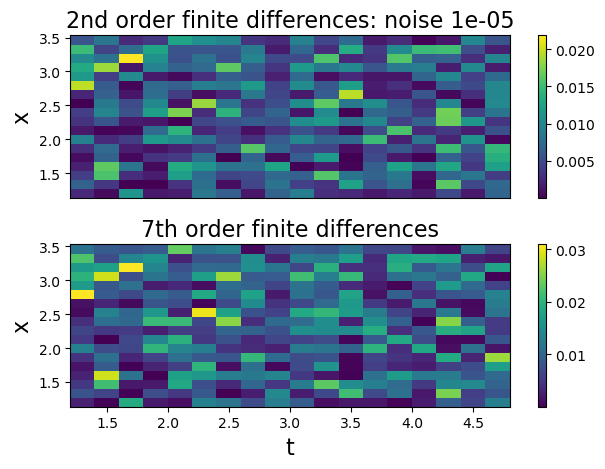

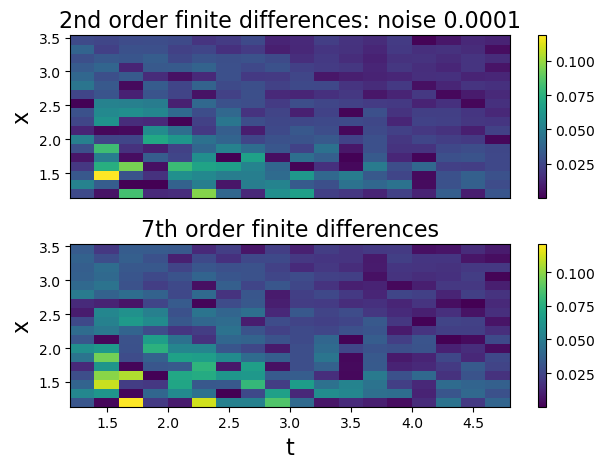

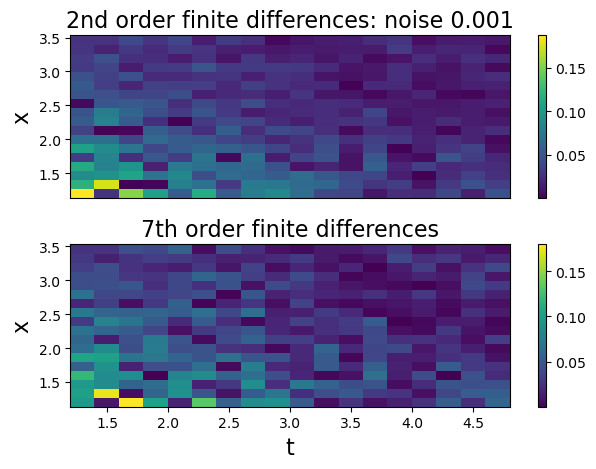

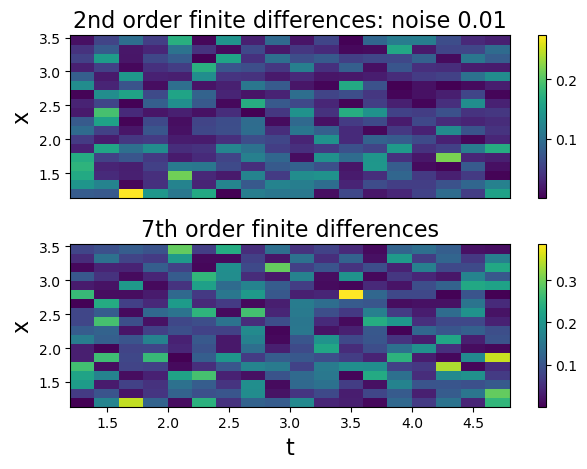

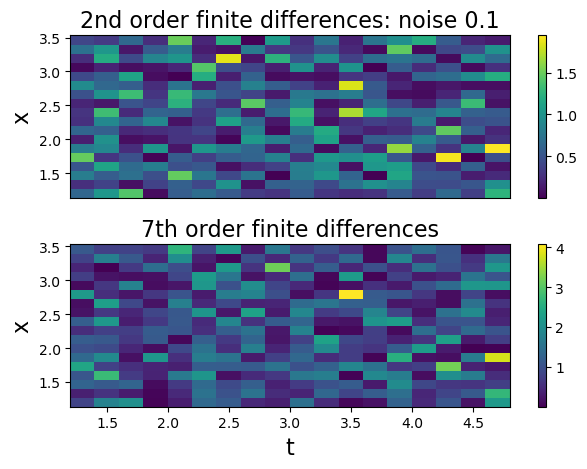

In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / 200 * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / 300 * (x[len(x)-1] - x[0]) + x[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

for target_noise in noise_levels:
    svs = jacobi_criterion(u,space_range,time_range,fd_orders,target_noise)
    plot_result_jacobi(svs,t_grid,x_grid,target_noise=target_noise,fd_orders=fd_orders)

#### Frobenius Normalisation 

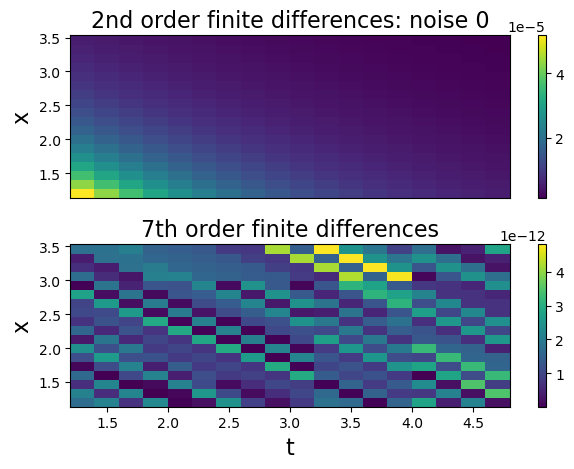

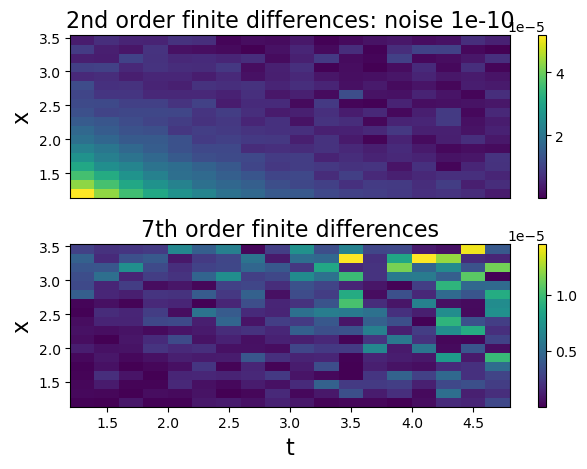

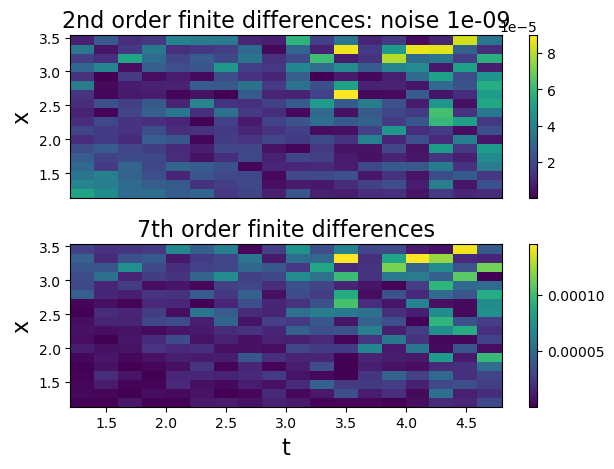

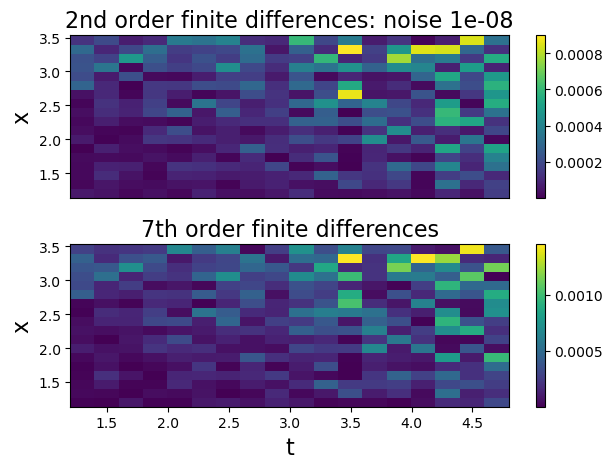

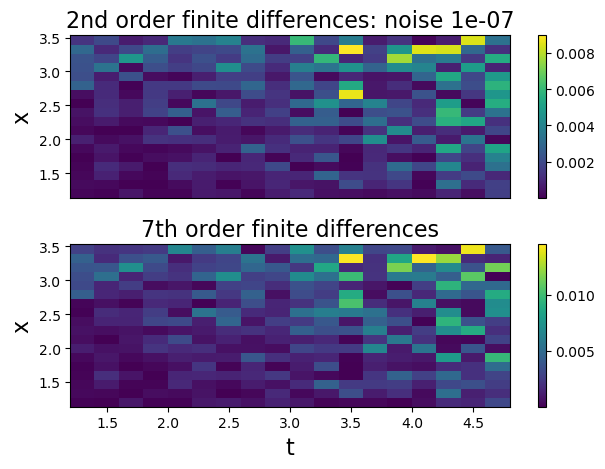

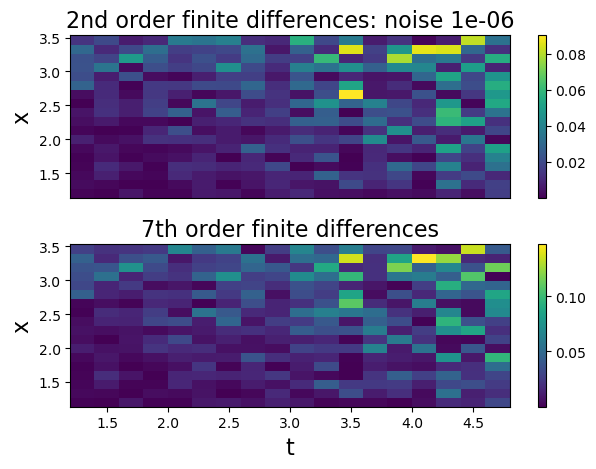

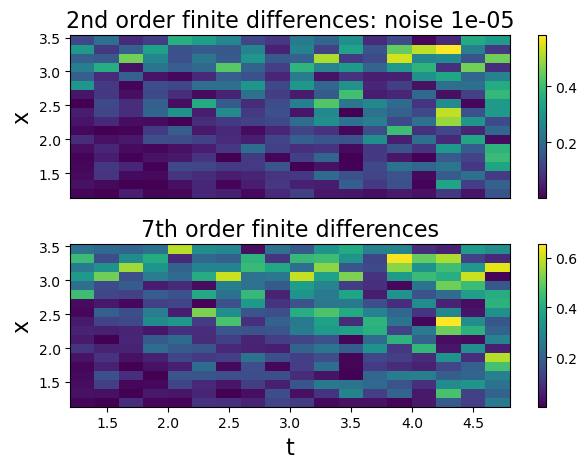

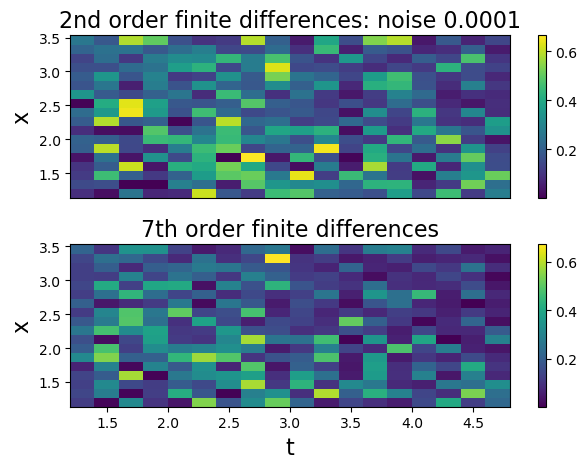

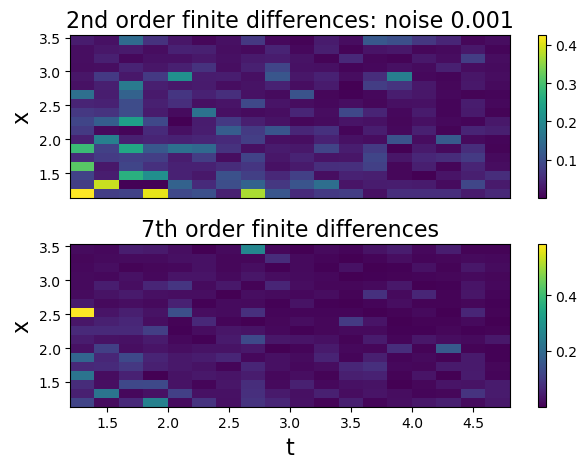

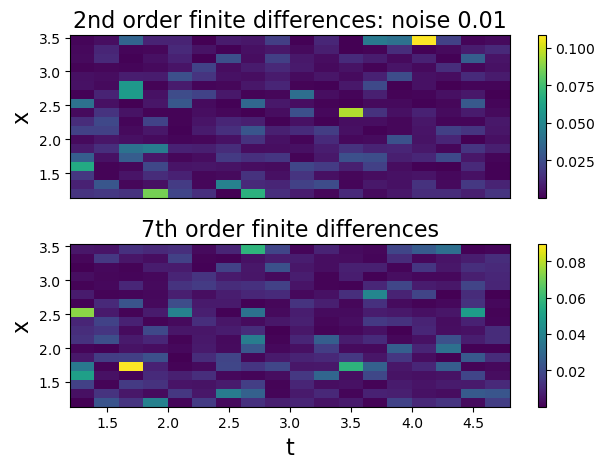

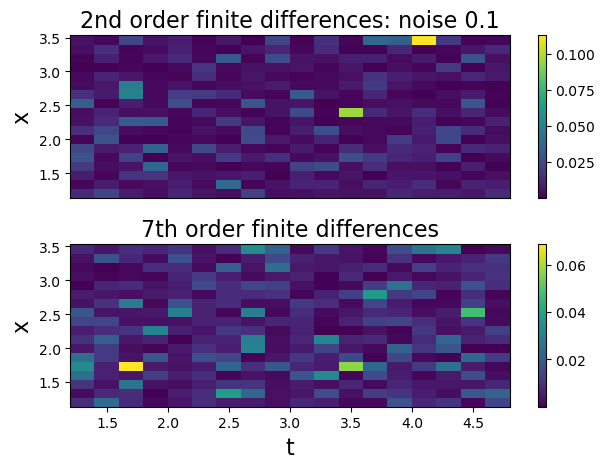

In [11]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / 200 * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / 300 * (x[len(x)-1] - x[0]) + x[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

for target_noise in noise_levels:
    svs = jacobi_criterion(u,space_range,time_range,fd_orders,target_noise,normalise=normalise_frobenius)
    plot_result_jacobi(svs,t_grid,x_grid,target_noise=target_noise,fd_orders=fd_orders)

#### Min Max Normalisation

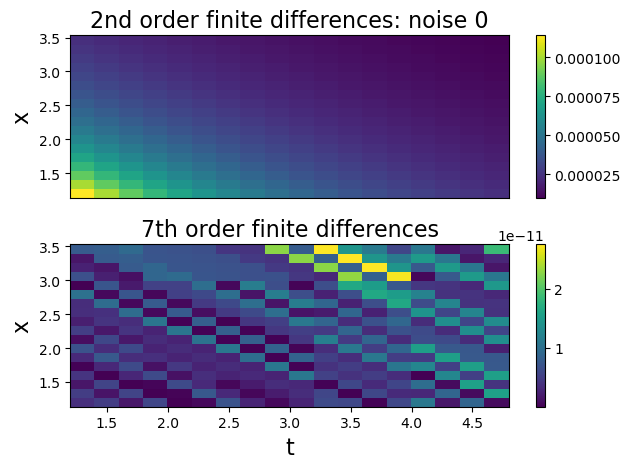

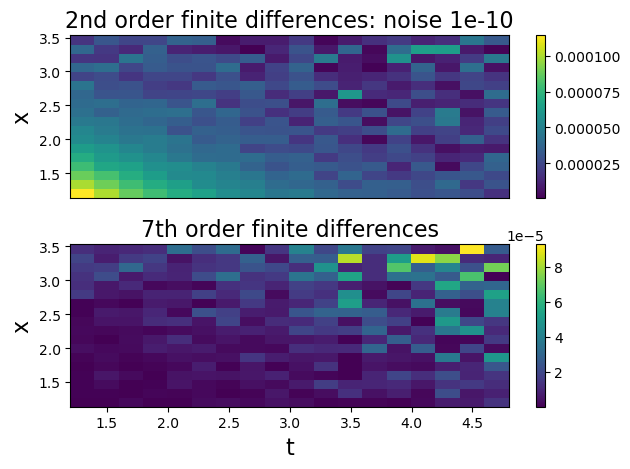

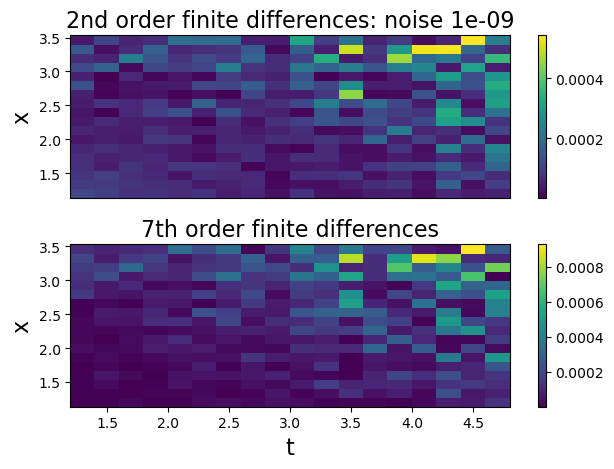

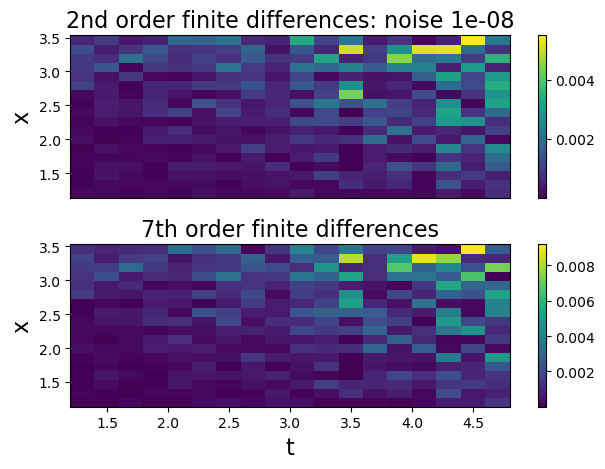

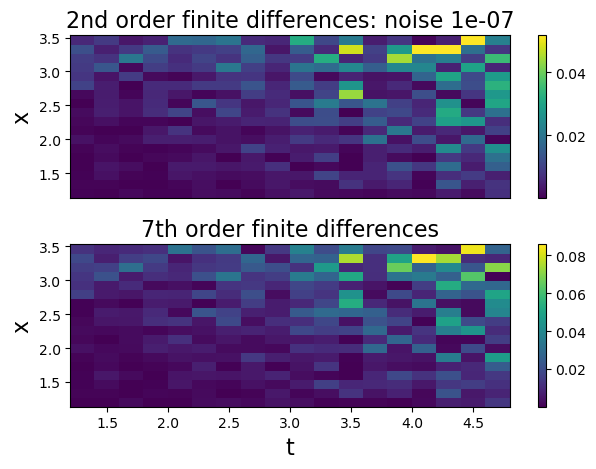

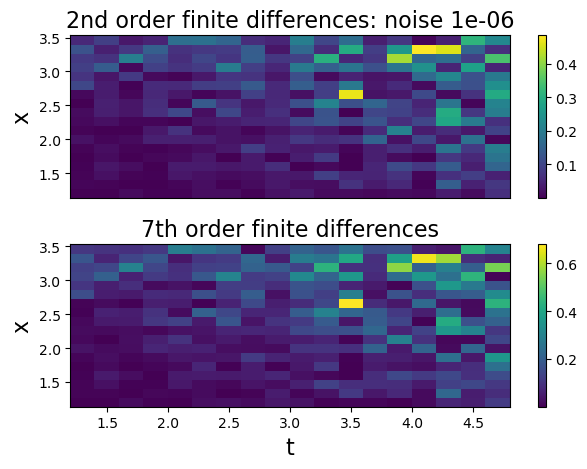

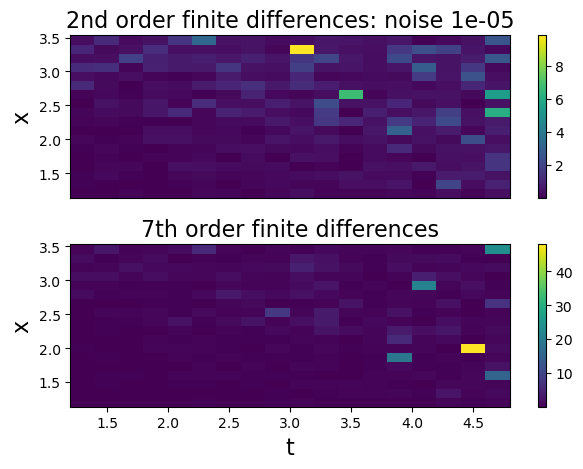

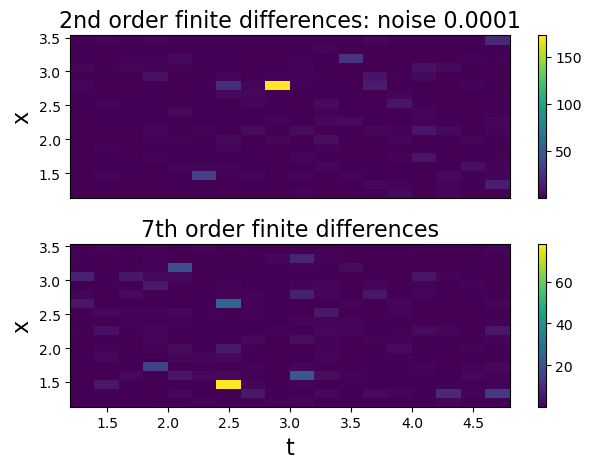

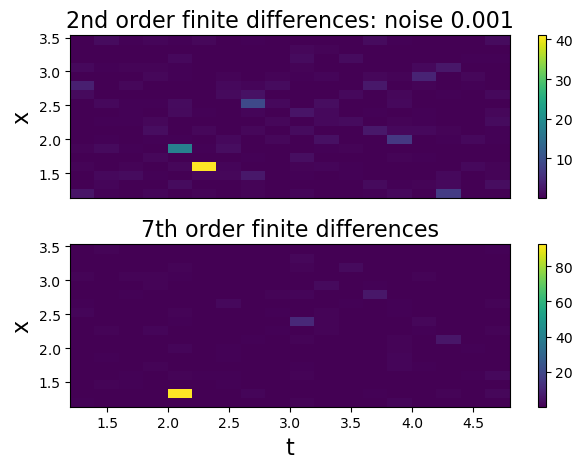

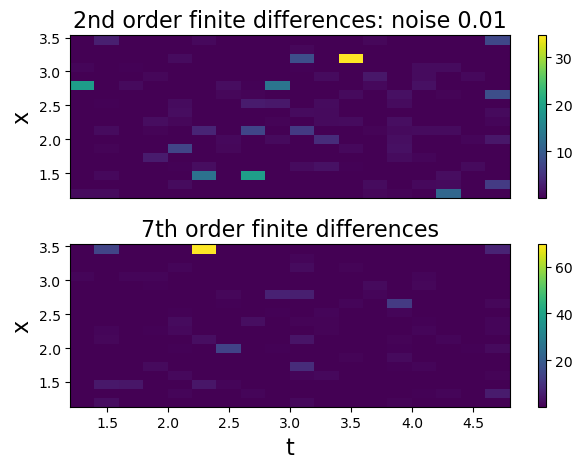

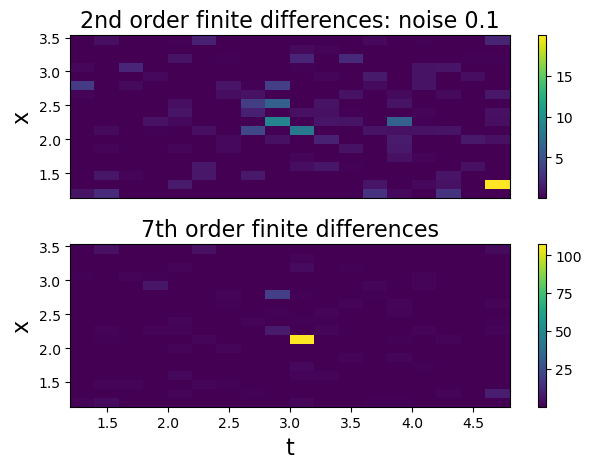

In [12]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / 200 * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / 300 * (x[len(x)-1] - x[0]) + x[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

for target_noise in noise_levels:
    svs = jacobi_criterion(u,space_range,time_range,fd_orders,target_noise,normalise=normalise_minmax)
    plot_result_jacobi(svs,t_grid,x_grid,target_noise=target_noise,fd_orders=fd_orders)